## Introduction
The 2019 novel coronavirus (COVID-19) presents several unique features. While the diagnosis is confirmed using polymerase chain reaction (PCR), infected patients with pneumonia may present on chest X-ray and computed tomography (CT) images with a pattern that is only moderately characteristic for the human eye Ng, 2020. Fast diagnostic methods can control and prevent the spread oand assist physicians to better manage patients in high workload conditions. COVID-19’s rate of transmission depends on our capacity to reliably identify infected patients with a low rate of false negatives. In addition, a low rate of false positives is required to avoid further increasing the burden on the healthcare system by unnecessarily exposing patients to quarantine if that is not required. Along with proper infection control, it is evident that timely detection of the disease would enable the implementation of all the supportive care required by patients affected by COVID-19.

## Exploratory Analysis


In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 


There is 0 csv file in the current version of the dataset:


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day4.jpeg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day0.jpeg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig2.jpeg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day2.jpg
/kaggle/input/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg
/kaggle/input/xray_d

In [3]:
train_dir = '/kaggle/input/xray_dataset_covid19/train'
validation_dir ='/kaggle/input/xray_dataset_covid19/test'

In [4]:
train_normal_dir = os.path.join(train_dir,'NORMAL')
train_pneumonia_dir = os.path.join(train_dir,'PNEUMONIA')
validation_normal_dir = os.path.join(validation_dir,'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir,'PNEUMONIA')

In [5]:
train_normal_names = os.listdir(train_normal_dir)
print(train_normal_names[:10])

train_pneumonia_names = os.listdir(train_pneumonia_dir)
print(train_pneumonia_names[:10])

['IM-0101-0001.jpeg', 'IM-0013-0001.jpeg', 'IM-0103-0001.jpeg', 'IM-0009-0001.jpeg', 'IM-0091-0001.jpeg', 'IM-0070-0001.jpeg', 'IM-0059-0001.jpeg', 'IM-0097-0001.jpeg', 'IM-0015-0001.jpeg', 'NORMAL2-IM-0027-0001.jpeg']
['ARDSSevere.png', '1-s2.0-S1684118220300682-main.pdf-002-a1.png', 'jkms-35-e79-g001-l-c.jpg', '2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg', '171CB377-62FF-4B76-906C-F3787A01CB2E.jpeg', 'covid-19-pneumonia-12.jpg', '31BA3780-2323-493F-8AED-62081B9C383B.jpeg', 'covid-19-pneumonia-15-PA.jpg', 'all14238-fig-0001-m-c.jpg', '1-s2.0-S1684118220300682-main.pdf-003-b1.png']


In [6]:
print('total training normal-rays :', len(os.listdir(train_normal_dir)))
print('total training Pneumonia x-rays:', len(os.listdir(train_pneumonia_dir)))
print('total validation normal-rays :', len(os.listdir(validation_normal_dir)))
print('total validation Pneumonia x-rays:', len(os.listdir(validation_pneumonia_dir)))

total training normal-rays : 74
total training Pneumonia x-rays: 74
total validation normal-rays : 20
total validation Pneumonia x-rays: 20


In [7]:
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import cv2 

#filtering warnings
import warnings
warnings.filterwarnings('ignore')

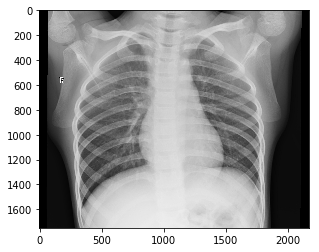

In [8]:
plt.imshow(cv2.imread("/kaggle/input/xray_dataset_covid19/train/NORMAL/NORMAL2-IM-0013-0001.jpeg"))

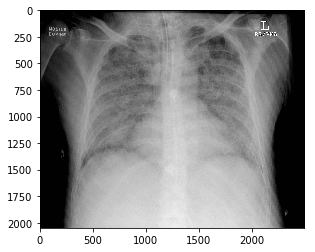

In [9]:
plt.imshow(cv2.imread("/kaggle/input/xray_dataset_covid19/train/PNEUMONIA/acute-respiratory-distress-syndrome-ards-1.jpg"))

In [10]:
#path to data
path = '/kaggle/input/xray_dataset_covid19/'

#Training Images
train_norm = os.listdir(path + "train/NORMAL")
train_covid = os.listdir(path + "train/PNEUMONIA")

#Testing Images
test_norm = os.listdir(path + "test/NORMAL")
test_covid = os.listdir(path + "test/PNEUMONIA")

In [11]:
#Dataframe function
def dataframe(filenames, classes):
    return pd.DataFrame({'Filename':filenames, 'Class':[classes]*len(filenames)})

#Forming Train and Test Dataframe
train_norm_df = dataframe(train_norm, 'Normal')
train_covid_df = dataframe(train_covid, 'Covid')

test_norm_df = dataframe(test_norm, 'Normal')
test_covid_df = dataframe(test_covid, 'Covid')

#Concating both classes into single datarame
train_df = pd.concat([train_norm_df, train_covid_df], axis=0)
test_df = pd.concat([test_norm_df, test_covid_df], axis=0)

In [12]:
#Path maker function
def pathmaker(df_name, df, empty_list):
    for i in df_name.values:
        if i[1] == 'Normal':
            empty_list.append(str(path + df + '/NORMAL/'+i[0]))
        else:
            empty_list.append(str(path + df + '/PNEUMONIA/'+i[0]))


#Empty list to be passed in path maker
train_path = []
test_path = []

#Assigning Path maker
pathmaker(train_df, 'train', train_path)
pathmaker(test_df, 'test', test_path)

train_df['Path'] = train_path
test_df['Path'] = test_path

#Shuffling / Re-arranging rows
train_df = train_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]
test_df = test_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]

train_df.head()

,Class,Path
0,Normal,/kaggle/input/xray_dataset_covid19/train/NORMA...
1,Normal,/kaggle/input/xray_dataset_covid19/train/NORMA...
2,Normal,/kaggle/input/xray_dataset_covid19/train/NORMA...
3,Normal,/kaggle/input/xray_dataset_covid19/train/NORMA...
4,Covid,/kaggle/input/xray_dataset_covid19/train/PNEUM...


Text(0.5, 1.0, 'COVID-19')

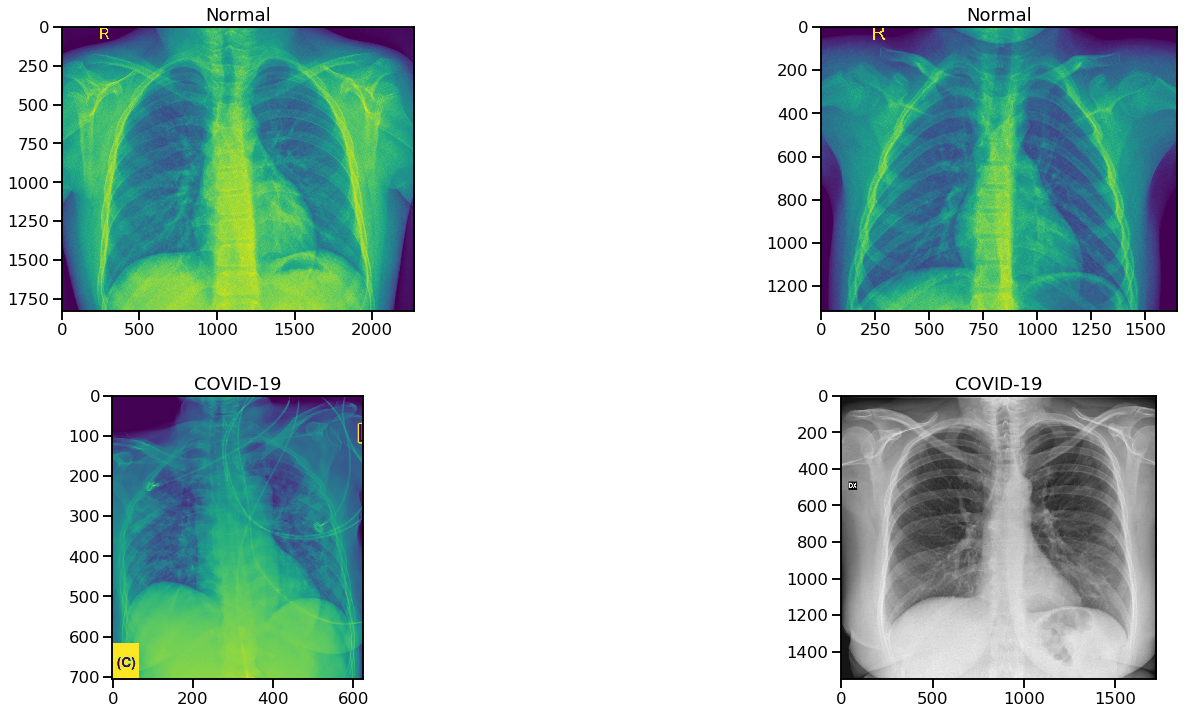

In [13]:
# Plotting Normal VS Covid in Grid

sns.set_context('talk')
plt.figure(figsize=(25,12))
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Normal']['Path'].values[0]))
plt.title('Normal')

plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Normal']['Path'].values[6]))
plt.title('Normal')

plt.subplot(2, 2, 3)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Covid']['Path'].values[28]))
plt.title('COVID-19')

plt.subplot(2, 2, 4)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Covid']['Path'].values[26]))
plt.title('COVID-19')

Text(0.5, 1.0, 'Category Count')

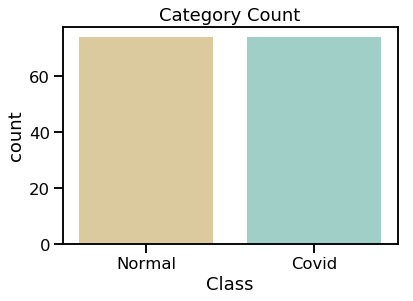

In [14]:
#Category count Plot
sns.countplot(train_df['Class'], palette='BrBG')
plt.title('Category Count')

## Image processing

In [15]:
# Image to matrix function

def img_to_mtx(data, empty_array):
    for i in data:
        temp_img = image.load_img(i, target_size=(150,150))
        temp_img = img_to_array(temp_img)
        empty_array.append(temp_img)

#empty list
train_imgs = []
test_imgs = []

#Applying Image to Matrix
img_to_mtx(train_df['Path'], train_imgs)
img_to_mtx(test_df['Path'], test_imgs)

#keras preprocessing
train_imgs = preprocess_input(np.array(train_imgs))
test_imgs = preprocess_input(np.array(test_imgs))

In [16]:
#String to Numeric Label
train_df['Class'] = train_df['Class'].replace(['Covid','Normal'], [1,0])
test_df['Class'] = test_df['Class'].replace(['Covid','Normal'], [1,0])

#defining output layer's output
ytrain = to_categorical(train_df['Class'], num_classes=2)

Implementation of Early Stopping module & Saving Best Model Architecture

In [17]:
#Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('best_mod.h5', save_best_only=True, monitor='accuracy')

#early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=10)

# Deep Neural Network - Implementing CNN

In [18]:
model = Sequential()

#Normalization & Input
model.add(BatchNormalization(input_shape=(150, 150, 3)))

#CNN
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout
model.add(Dropout(0.25))

#Flattening I/P
model.add(Flatten())

#Dense layer
model.add(Dense(128, activation='relu'))

#Dropout
model.add(Dropout(0.1))

#Output Layer with sigmoid
model.add(Dense(2, activation='sigmoid'))

#Adam as optimizer, Accuracy as evaluation metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
#overview of deep neural network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 180000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               23040128  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

# Execution

In [20]:
#Model fitting and tracking historical accuracy / error score
history = model.fit(train_imgs, ytrain, 
          validation_split=0.10, 
          epochs=20, batch_size=32, shuffle=True, 
          callbacks=[model_chkpt, early_stopping]
         )

Train on 133 samples, validate on 15 samples
Epoch 1/20
133/133 [==============================] - 5s 34ms/sample - loss: 9.4065 - accuracy: 0.5865 - val_loss: 30.0495 - val_accuracy: 0.7667
Epoch 2/20
133/133 [==============================] - 1s 9ms/sample - loss: 4.2223 - accuracy: 0.8233 - val_loss: 8.6810 - val_accuracy: 0.8667
Epoch 3/20
133/133 [==============================] - 1s 7ms/sample - loss: 0.9943 - accuracy: 0.9398 - val_loss: 15.6415 - val_accuracy: 0.7333
Epoch 4/20
133/133 [==============================] - 1s 6ms/sample - loss: 0.7141 - accuracy: 0.9511 - val_loss: 5.9886 - val_accuracy: 0.8667
Epoch 5/20
133/133 [==============================] - 1s 7ms/sample - loss: 0.2843 - accuracy: 0.9812 - val_loss: 3.5291 - val_accuracy: 0.8333
Epoch 6/20
133/133 [==============================] - 0s 800us/sample - loss: 0.4045 - accuracy: 0.9436 - val_loss: 2.0691 - val_accuracy: 0.8000
Epoch 7/20
133/133 [==============================] - 0s 679us/sample - loss: 0.0813 -

# Learning curve over Number of Iterations

Text(0, 0.5, 'Error')

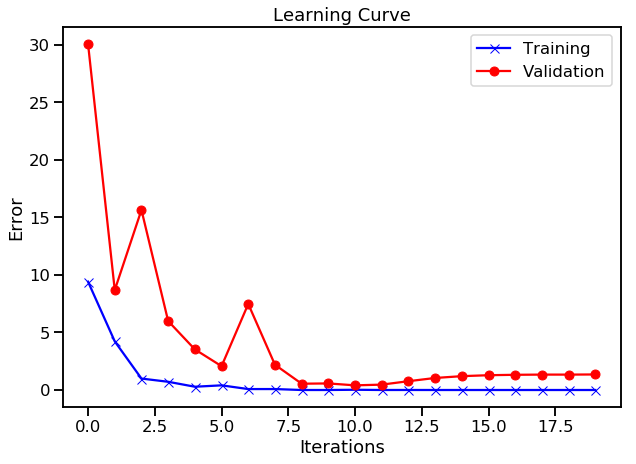

In [21]:
#plotting Learning curve over No. of Iterations
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], 'b', label='Training', marker='x')
plt.plot(history.history['val_loss'], 'r', label='Validation', marker='o')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Error')

Prediction

In [22]:
#prediction on test set
pred = model.predict(test_imgs, batch_size=32)
#pred

#converting Probabilities to labels
label = np.argmax(pred, axis=1)
#label

# Performance Evaluation - Accuracy, Classification Report & Confusion Matrix

In [23]:
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, test_df['Class'].values), '\n')

#precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, test_df['Class'].values))

Accuracy Score :  1.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



Text(0.5, 1.0, 'Confusion Matrix')

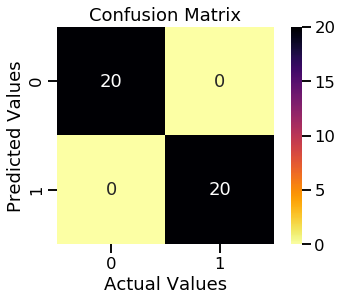

In [24]:
#plotting confusion matrix
sns.heatmap(confusion_matrix(label, test_df['Class'].values), annot=True, cmap='inferno_r', square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')